In [32]:
import pandas as pd
import scipy.stats
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [33]:
start = dt.datetime.now()

In [34]:
data = pd.read_csv("applications data.csv")

In [35]:
data.shape

(1000000, 10)

In [36]:
data.head()

,record,date,ssn,firstname,lastname,address,zip5,dob,homephone,fraud_label
0,1,20160101,379070012,XRRAMMTR,SMJETJMJ,6861 EUTST PL,2765,19070626,1797504115,0
1,2,20160101,387482503,MAMSTUJR,RTTEMRRR,7280 URASA PL,57169,19340615,4164239415,1
2,3,20160101,200332444,SZMMUJEZS,EUSEZRAE,5581 RSREX LN,56721,19070626,216537580,0
3,4,20160101,747451317,SJJZSXRSZ,ETJXTXXS,1387 UJZXJ RD,35286,19440430,132144161,0
4,5,20160101,24065868,SSSXUEJMS,SSUUJXUZ,279 EAASA WY,3173,19980315,6101082272,0


### FIX FRIVOLOUS VALUES

In [37]:
df = data.copy()

#fix datatype
df['date'] = pd.to_datetime(df.date.astype(str).apply(lambda x: x[:4]+'-'+x[4:6]+'-'+x[6:]))
df['zip5'] = df['zip5'].apply(lambda x: '{0:0>5}'.format(x))

#fix frivolous values
#ssn
df.loc[df.ssn==999999999,'ssn'] = df[df.ssn==999999999]['record']
df['ssn'] = df['ssn'].apply(lambda x: '{0:0>9}'.format(x))
#address
df.loc[df.address=='123 MAIN ST','address'] = \
    df.loc[df.address=='123 MAIN ST','record'].apply(lambda x: str(x))
#dob
df.loc[df.dob==19070626,'dob'] =df.loc[df.dob==19070626]['record']
df['dob'] = df['dob'].apply(lambda x: '{0:0>8}'.format(x))
#homephone
df.loc[df.homephone==9999999999,'homephone'] = df.loc[df.homephone==9999999999]['record']
df['homephone'] = df['homephone'].apply(lambda x: '{0:0>10}'.format(x))
df.dtypes

record                  int64
date           datetime64[ns]
ssn                    object
firstname              object
lastname               object
address                object
zip5                   object
dob                    object
homephone              object
fraud_label             int64
dtype: object

In [38]:
df.head()

,record,date,ssn,firstname,lastname,address,zip5,dob,homephone,fraud_label
0,1,2016-01-01,379070012,XRRAMMTR,SMJETJMJ,6861 EUTST PL,02765,00000001,1797504115,0
1,2,2016-01-01,387482503,MAMSTUJR,RTTEMRRR,7280 URASA PL,57169,19340615,4164239415,1
2,3,2016-01-01,200332444,SZMMUJEZS,EUSEZRAE,5581 RSREX LN,56721,00000003,0216537580,0
3,4,2016-01-01,747451317,SJJZSXRSZ,ETJXTXXS,1387 UJZXJ RD,35286,19440430,0132144161,0
4,5,2016-01-01,024065868,SSSXUEJMS,SSUUJXUZ,279 EAASA WY,03173,19980315,6101082272,0


### Combine Related Variables

In [39]:
df['name'] = df['lastname'] + ', ' + df['firstname']
df['addr'] = df['address'] + ', ' + df['zip5']

df['name-dob'] = df['name'] + df['dob']
df['name-addr'] = df['name'] + df['addr']
df['name-homephone'] = df['name'] + df['homephone']
df['dob-addr'] = df['dob'] + df['addr']
df['dob-homephone'] = df['dob'] + df['homephone']
df['addr-homephone'] = df['addr'] + df['homephone']

df['name-dob-addr'] = df['name-dob'] + df['addr']
df['name-dob-homephone'] = df['name-dob'] + df['homephone']
df['name-addr-homephone'] = df['name-addr'] + df['homephone']
df['dob-addr-homephone'] = df['dob-addr'] + df['homephone']

df['name-dob-addr-homephone'] = df['name-dob-addr'] + df['homephone']

for i in df.columns[3:9]:
    df['ssn-{}'.format(i)] = df['ssn'] + df[i]

for i in ['name','addr','name-dob']:
    df['ssn-{}'.format(i)] = df['ssn'] + df[i]

df.shape

(1000000, 32)

In [40]:
df.shape

(1000000, 32)

In [41]:
attributes = list(df.columns)
for col in ['record', 'date', 'firstname', 'lastname', 'zip5', 'fraud_label']:
    attributes.remove(col)
print(len(attributes))

26


In [42]:
attributes

['ssn',
 'address',
 'dob',
 'homephone',
 'name',
 'addr',
 'name-dob',
 'name-addr',
 'name-homephone',
 'dob-addr',
 'dob-homephone',
 'addr-homephone',
 'name-dob-addr',
 'name-dob-homephone',
 'name-addr-homephone',
 'dob-addr-homephone',
 'name-dob-addr-homephone',
 'ssn-firstname',
 'ssn-lastname',
 'ssn-address',
 'ssn-zip5',
 'ssn-dob',
 'ssn-homephone',
 'ssn-name',
 'ssn-addr',
 'ssn-name-dob']

In [43]:
finalDF = df[['record','date']]

for val in attributes:
    df1 = df[['record','date', val]].copy()
    df2 = df1.copy()
    lags = [0, 1, 3, 7, 14, 30]
    
    for lag in lags:
        temp_name = 'date_{}'.format(lag)
        df2[temp_name] = df2['date'] + dt.timedelta(lag)

    dff = df1.merge(df2, on=val)

    tmp = dff[(dff['record_x']>dff['record_y'])][['record_x','date_y']].\
          groupby('record_x').last()['date_y'].reset_index()
    tmp.columns = ['record','last_seen']
    df1 = df1.merge(tmp, how='left', on='record')
    df1['#d_since'] = df1['date'] - df1['last_seen']
    df1['#d_since'] = df1['#d_since'].dt.days
    df1['#d_since_start'] = (df1['date']-df1['date'].min()).dt.days
    df1['#d_since'] = df1['#d_since'].fillna(df1['#d_since_start'])
    
    df1.drop(columns=['last_seen','#d_since_start'], inplace=True)

    for lag in lags:
        temp = dff[(dff['record_x']>=dff['record_y']) & (dff['date_x']<=dff['date_{}'.format(lag)])]
        tempCount = temp[['record_x','record_y']].groupby('record_x').count().reset_index()
        temp_name = 'ps_{}d_count'.format(lag)
        tempCount.columns = ['record', temp_name]
        df1 = df1.merge(tempCount, left_on='record',right_on='record')

    for i in [1]:
        for j in [3, 7, 14, 30]:
            temp_name = 'ps_{}d_ps{}d_avg'.format(i,j)
            numerator = 'ps_{}d_count'.format(i)
            denominator = 'ps_{}d_count'.format(j)
            df1[temp_name] = df1[numerator] / (df1[denominator]/j)
    
    df1.drop(columns=['date',val], inplace=True)
    df1 = df1.set_index('record')
    df1 = df1.add_prefix('{}_'.format(val))
    finalDF = finalDF.merge(df1, left_on='record', right_index=True)

In [44]:
finalDF.shape

(1000000, 288)

In [45]:
finalDF.head()

,record,date,ssn_#d_since,ssn_ps_0d_count,ssn_ps_1d_count,ssn_ps_3d_count,ssn_ps_7d_count,ssn_ps_14d_count,ssn_ps_30d_count,ssn_ps_1d_ps3d_avg,...,ssn-name-dob_ps_0d_count,ssn-name-dob_ps_1d_count,ssn-name-dob_ps_3d_count,ssn-name-dob_ps_7d_count,ssn-name-dob_ps_14d_count,ssn-name-dob_ps_30d_count,ssn-name-dob_ps_1d_ps3d_avg,ssn-name-dob_ps_1d_ps7d_avg,ssn-name-dob_ps_1d_ps14d_avg,ssn-name-dob_ps_1d_ps30d_avg
0,1,2016-01-01,0.0,1,1,1,1,1,1,3.0,...,1,1,1,1,1,1,3.0,7.0,14.0,30.0
1,2,2016-01-01,0.0,1,1,1,1,1,1,3.0,...,1,1,1,1,1,1,3.0,7.0,14.0,30.0
2,3,2016-01-01,0.0,1,1,1,1,1,1,3.0,...,1,1,1,1,1,1,3.0,7.0,14.0,30.0
3,4,2016-01-01,0.0,1,1,1,1,1,1,3.0,...,1,1,1,1,1,1,3.0,7.0,14.0,30.0
4,5,2016-01-01,0.0,1,1,1,1,1,1,3.0,...,1,1,1,1,1,1,3.0,7.0,14.0,30.0


In [46]:
finalDF.describe()

,record,ssn_#d_since,ssn_ps_0d_count,ssn_ps_1d_count,ssn_ps_3d_count,ssn_ps_7d_count,ssn_ps_14d_count,ssn_ps_30d_count,ssn_ps_1d_ps3d_avg,ssn_ps_1d_ps7d_avg,...,ssn-name-dob_ps_0d_count,ssn-name-dob_ps_1d_count,ssn-name-dob_ps_3d_count,ssn-name-dob_ps_7d_count,ssn-name-dob_ps_14d_count,ssn-name-dob_ps_30d_count,ssn-name-dob_ps_1d_ps3d_avg,ssn-name-dob_ps_1d_ps7d_avg,ssn-name-dob_ps_1d_ps14d_avg,ssn-name-dob_ps_1d_ps30d_avg
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,...,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,500000.500000,163.702278,1.007305,1.014924,1.020140,1.026348,1.034592,1.050825,2.995255,6.973423,...,1.007221,1.014677,1.019561,1.025098,1.032193,1.045940,2.995696,6.976355,13.910634,29.620751
std,288675.278933,105.164030,0.223356,0.381210,0.423193,0.453557,0.477650,0.513332,0.083701,0.309702,...,0.223152,0.380843,0.422242,0.451121,0.471479,0.496147,0.079636,0.292048,0.801384,2.398072
min,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.428571,0.500000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.428571,0.500000,0.875000,1.764706
25%,250000.750000,72.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,7.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,7.000000,14.000000,30.000000
50%,500000.500000,155.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,7.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,7.000000,14.000000,30.000000
75%,750000.250000,251.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,7.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,7.000000,14.000000,30.000000
max,1000000.000000,365.000000,21.000000,34.000000,34.000000,34.000000,34.000000,34.000000,3.000000,7.000000,...,21.000000,34.000000,34.000000,34.000000,34.000000,34.000000,3.000000,7.000000,14.000000,30.000000


### Risk Table: Likelihood of Fraud for That Day of the Week

In [47]:
# 0-Monday, 6-Sunday
finalDF['weekday'] = finalDF.date.dt.dayofweek
finalDF = finalDF.merge(df[['record','fraud_label']])
finalDF.shape

(1000000, 290)

In [48]:
tt = finalDF[finalDF.date<'2016-11-01'].copy()
oot = finalDF[finalDF.date>='2016-11-01'].copy()

In [49]:
c = 4
nmid = 20
y_avg = tt['fraud_label'].mean()
y_weekday_avg = tt.groupby('weekday')['fraud_label'].mean()
num_instances_weekday = tt.groupby('weekday').size()
y_weekday_smooth = y_avg + (y_weekday_avg - y_avg)/(1 + np.exp(-(num_instances_weekday-nmid)/c))
tt['weekday_risk'] = tt['weekday'].map(y_weekday_smooth)
oot['weekday_risk'] = oot['weekday'].map(y_weekday_smooth)

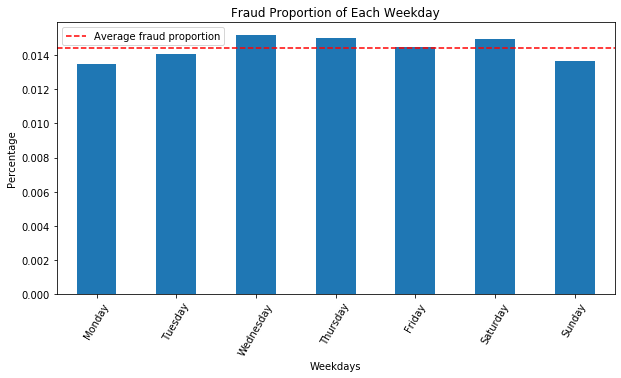

In [18]:
plt.figure(figsize=(10,5))
y_weekday_smooth.plot(kind='bar')
plt.xticks(range(7),
           ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
           rotation=60)
plt.axhline(y_avg, color='r', linestyle='--')
plt.xlabel('Weekdays')
plt.ylabel('Percentage')
plt.title('Fraud Proportion of Each Weekday')
plt.legend(['Average fraud proportion'])
plt.show()

In [78]:
y_weekday_smooth.to_csv('risk table.csv')

In [54]:
import seaborn as sns

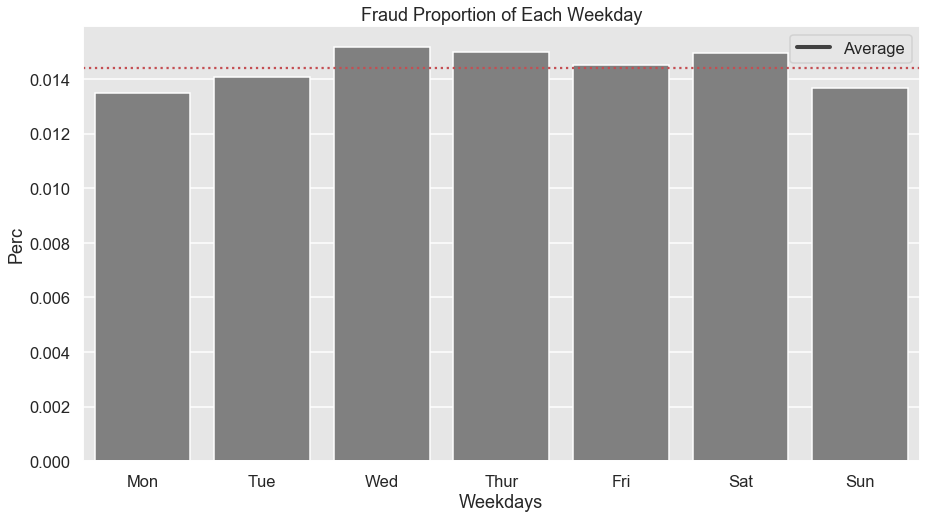

In [76]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_color_codes()
plt.figure(figsize = (15,8))
sns.barplot(x=['Mon','Tue','Wed','Thur','Fri','Sat','Sun'],y=y_weekday_smooth,color = 'grey')
plt.yticks()
plt.axhline(y_avg, color='r', linestyle=':')
plt.xlabel('Weekdays')
plt.ylabel('Perc')
plt.title('Fraud Proportion of Each Weekday')
plt.legend(['Average'])
plt.show()

In [50]:
print(tt.shape)
print(oot.shape)

(833507, 291)
(166493, 291)


In [51]:
tt.to_csv('trntst.csv', index=False)
oot.to_csv('oot.csv', index=False)

In [52]:
vals = list(tt.columns)
vals.remove('record')
vals.remove('date')
vals.remove('weekday')
vals2 = vals.copy()
vals2.remove('weekday_risk')

In [79]:
tt[vals].describe().to_csv('train_test_data_summary.csv')
oot[vals].describe().to_csv('oot_data_summary.csv')
finalDF[vals2].describe().to_csv('variables_summary.csv')

In [23]:
print("Duration:", dt.datetime.now()-start)

Duration: 0:11:41.118183
